In [1]:
%matplotlib inline

import numpy as np
import torch, h5py
import json
import pandas as pd

from kymatio.numpy import Scattering1D

from librosa.display import specshow
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
# get class map from the csv file
data_dir = '../datasets/SOL-0.9HQ-PMT/'
df = pd.read_csv(data_dir + 'SOL-0.9HQ-PMT_meta.csv')
classes = df[['modulation technique', 'label']
            ].value_counts().index.to_list()
class_map = dict([x for x in sorted(classes, key=lambda x: x[1])])
             
# class abbrevation map
with open(data_dir + 'class_abbrevation.json', 'r') as f:
    class_abbrv = json.load(f)

In [3]:
# scattering1d config
kwargs = {
    'shape': 2**18,
    'J': 13,
    'T': 2**13,
    'Q': (8, 2)}

In [4]:
scat1d = Scattering1D(**kwargs)
meta = scat1d.meta()
sr = 44100
freq_min = 32

# carrier center frequencies condition >= freq_min
freq_cnd = meta['xi'][:, 0] * sr >= freq_min

# indices for scat coefficient to extract 
idx_S1 = np.where(np.logical_and(meta['order'] == 1, freq_cnd))[0]  # order 1
idx_S2 = np.where(np.logical_and(meta['order'] == 2, freq_cnd))[0] # order 2
idx_S1S2 = np.where(np.logical_and(meta['order'] != 0, freq_cnd))[0] # order 1 and 2

In [5]:
xi1s = np.array([sr * psi['xi'] for psi in scat1d.psi1_f])
xi2s = np.array([sr * psi['xi'] for psi in scat1d.psi2_f])

sigma1s = [sr * psi['sigma'] for psi in scat1d.psi1_f]
sigma2s = [sr * psi['sigma'] for psi in scat1d.psi2_f]

mid_xi1s = np.sqrt(xi1s[1:] * xi1s[:-1])  # center for two valuess in a log scale
mid_xi2s = np.sqrt(xi2s[1:] * xi2s[:-1])
x_coords = np.array([sr//2] + list(mid_xi2s) + [xi2s[-1]-sigma2s[-1]])
y_coords = np.array([sr//2] + list(mid_xi1s) + [xi1s[-1]-sigma1s[-1]])

x_coords = np.hstack((x_coords, x_coords[-1] / 2))

In [6]:
# u-log to input data
mu = torch.tensor(np.load('SOL-0.9HQ-PMT/scat1d/stats/mu_S1S2.npy'))
c = torch.tensor([1e-1])

In [7]:
# load extracted relevance on the dataset
data = h5py.File('results/feature_relevance.hdf5', 'r')
def printname(name):
    print(name)
data.visit(printname)

composite_EpsilonPlus
composite_EpsilonPlus/bisbigliando
composite_EpsilonPlus/bisbigliando/feature
composite_EpsilonPlus/bisbigliando/relevance
composite_EpsilonPlus/flatterzunge
composite_EpsilonPlus/flatterzunge/feature
composite_EpsilonPlus/flatterzunge/relevance
composite_EpsilonPlus/tremolo
composite_EpsilonPlus/tremolo/feature
composite_EpsilonPlus/tremolo/relevance
composite_EpsilonPlus/trill
composite_EpsilonPlus/trill/feature
composite_EpsilonPlus/trill/relevance
composite_EpsilonPlus/vibrato
composite_EpsilonPlus/vibrato/feature
composite_EpsilonPlus/vibrato/relevance
single_Epsilon
single_Epsilon/bisbigliando
single_Epsilon/bisbigliando/feature
single_Epsilon/bisbigliando/relevance
single_Epsilon/flatterzunge
single_Epsilon/flatterzunge/feature
single_Epsilon/flatterzunge/relevance
single_Epsilon/tremolo
single_Epsilon/tremolo/feature
single_Epsilon/tremolo/relevance
single_Epsilon/trill
single_Epsilon/trill/feature
single_Epsilon/trill/relevance
single_Epsilon/vibrato
sing

## Class-wise aggregation
Class-wise relevance maps


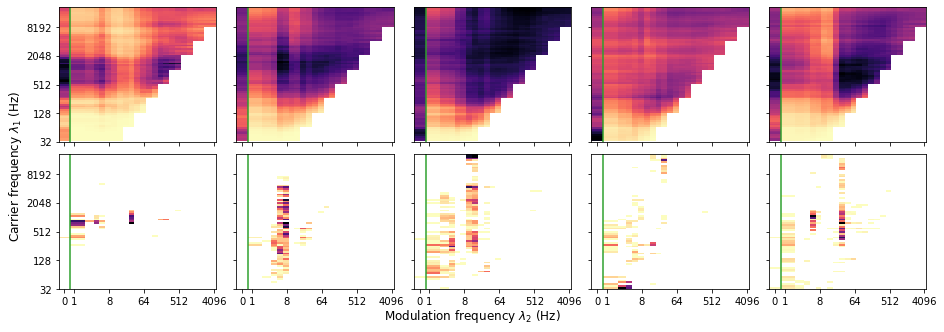

In [13]:
# top k argmax
top_k = 5
rule = 'composite_EpsilonPlus'

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(13, 4.5))
k = 0

for class_name in class_map:

    input_all = np.array(data[rule][class_name]['feature'])
    relevance_all = np.array(data[rule][class_name]['relevance'])

    input_all = torch.from_numpy(input_all)
    relevance_all = torch.from_numpy(relevance_all).mean(-1)

    # u-log to input data
    input_all = torch.log1p(input_all / (c[None, :, None] * mu[None, :, None] + 1e-8))
    input_all = input_all.squeeze().mean(-1).mean(0)

    # top n argmax
    relevance_top_argmax = torch.zeros(relevance_all.shape)

    for sample in range(relevance_all.shape[0]):
        sample_arg_idx = torch.topk(relevance_all[sample, :], top_k).indices 
        relevance_top_argmax[sample, sample_arg_idx] = 1

    relevance_all = relevance_top_argmax.sum(0)

    input_S2 = input_all[len(idx_S1):]
    relevance_S2 = relevance_all[len(idx_S1):]

    # convert into list representation
    Sx2 = [{'coef': input_S2[k], 'n': meta['n'][idx_S2[k],:].astype(int)} for k in range(input_S2.shape[-1])]
    input_feature = np.zeros((len(xi1s), 1+len(xi2s))) * np.nan

    input_feature[:len(idx_S1), -1] = input_all[:len(idx_S1)]

    for path in Sx2:
        n1 = path['n'][0]
        xi1 = xi1s[n1]
        n2 = path['n'][1]
        xi2 = xi2s[n2]
        if xi1 * sr >= freq_min:
            input_feature[n1, n2] = path['coef'] # / (xi1*xi2)

    # convert into list representation
    Sx2 = [{'coef': relevance_S2[k], 'n': meta['n'][idx_S2[k],:].astype(int)} for k in range(relevance_S2.shape[-1])]
    relevance = np.zeros((len(xi1s), 1+len(xi2s))) * np.nan

    relevance[:len(idx_S1), -1] = relevance_all[:len(idx_S1)]

    for path in Sx2:
        n1 = path['n'][0]
        xi1 = xi1s[n1]
        n2 = path['n'][1]
        xi2 = xi2s[n2]
        if xi1 * sr >= freq_min:
            relevance[n1, n2] = path['coef']

    specshow(
        input_feature, x_coords=x_coords, y_coords=y_coords,
        x_axis='cqt_hz', y_axis='cqt_hz', cmap='magma_r', ax=axs[0, k])
    x_ticklabels = list((lambda n: 8 ** n)(np.arange(5)))
    y_ticklabels = (lambda n: freq_min * 4 ** n)(np.arange(5))
    xpos_forS1 = np.sqrt(x_coords[-1] * x_coords[-2])
    max_xi2s = x_coords[np.where(np.isnan(input_feature[0,:]))[0][-1] + 1]
    axs[0, k].set_ylim(bottom=min(y_coords[y_coords >= freq_min]), top=max(y_coords))
    axs[0, k].axvline(x=x_coords[-2], color='tab:green')   
    axs[0, k].set(xlabel=None, ylabel=None)
    axs[0, k].set_ylim(bottom=freq_min, top=max(y_coords))
    axs[0, k].set_yticks(y_ticklabels)
    axs[0, k].set_yticklabels(y_ticklabels)
    axs[0, k].set_xlim(right=max_xi2s)

    # relevance = np.log1p(relevance / 1e-8)
    relevance[relevance==0] = np.nan
    specshow(
        relevance, x_coords=x_coords, y_coords=y_coords,
        x_axis='cqt_hz', y_axis='cqt_hz', cmap='magma_r', ax=axs[1, k])
    axs[1, k].set_ylim(bottom=min(y_coords[y_coords >= freq_min]), top=max(y_coords))
    axs[1, k].axvline(x=x_coords[-2], color='tab:green')
    axs[1, k].set(xlabel=None, ylabel=None)
    axs[1, k].set_ylim(bottom=freq_min, top=max(y_coords))
    axs[1, k].set_yticks(y_ticklabels)
    axs[1, k].set_yticklabels(y_ticklabels)
    axs[1, k].set_xlim(right=max_xi2s)
    axs[1, k].set_xticks([xpos_forS1] + x_ticklabels)
    axs[1, k].set_xticklabels([0] + x_ticklabels)

    k += 1

fig.supxlabel('Modulation frequency ' + r'$\lambda_2$ (Hz)')
fig.supylabel('Carrier frequency ' + r'$\lambda_1$ (Hz)')
plt.savefig('results/classwise_aggregation_top{}.pdf'.format(top_k))
# plt.savefig('results/classwise_aggregation_top{}.png'.format(top_k))